## <p style="text-align: center;">B9AI103_2122_TMD3_CA_1</p>
### <p style="text-align: center;"> Details </p>
#### <p style="text-align: center;">Name: Sunil Judhistira Gauda</p>
#### <p style="text-align: center;">Student ID : 10595858 </p>

#### Project - Speeach Emotion Detection using Audio Processing and Speeach Recognition API
##### Description
- Capture - Recording Audio and Saving it for analysis.
- Analysis - Checking the wawe of audio to get visual view of how our audio looks graphically
- Audio
- Using Logistic Regression and Datasets from the gratious Yelp, Amazon and imdb Datasets i have trained this models and provided a sentiment analysis over the input statement

### Business Undestanding
Words we use to speak provides combinations of diffrent letters to express emotion of a individual, with speach recognition and NLP we can use those words to describe a particular range of emotion, in this project 2 such extreme emotions are detected to analyze weather the person is **Happy** or **Sad**

#### Imports

Note : Some imports like pyaudio requires windows sepcific installation for VC++ library, please follow the instructions below with an andminstartor window of a Shell, inside your project environment.
* pip install pipwin
* pipwin install pyaudio

In [94]:
import pyaudio
import numpy as np
import wave
import speech_recognition as sr
from os import path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud, STOPWORDS

#Importing Pytorch
import torch

#Importing Wav2Vec
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer


#### Data Understanding

The data we consume is live data recorded via pyaudio interface, exploration of the data will begin after we record the audio.

##### Audio Parameters

* chunk - defines the arbitary number frame in terms of a memory chunk for the recorded audio
* format - defines output format which we will use to analysie the audio
* channels - defines number of audio channels we will be recording the audio in
* rate - defines what is the rate of playback as per each frame

In [95]:
chunk = 1024
format = pyaudio.paInt16
channels = 1
rate = 44100


##### Audio Recording

Audio Recording is done by using **pyaudio** , pyaudio provides us implementaion for recording and storing audio, which we will use to capture and analyse the data.

In [96]:
# Py audio Instance
p = pyaudio.PyAudio()

# Defining the audio Params and opening the record stream
stream = p.open(format=format,
                channels=channels,
                rate=rate,
                input=True,
                frames_per_buffer=chunk)

print("...Start Recording")

# Frame Variable - to capture the frames as int values
frames = []

# Mximum number of recording time - can be changed as required
seconds = 6

# Recording the audio
for i in range(0, int(rate/chunk*seconds)):
    data = stream.read(chunk)
    frames.append(data)

print("Recording Stopped...")

# Closing the record steam
stream.stop_stream()
stream.close()
p.terminate()

# Setting the audio params and saving it
wf = wave.open("output.wav", "wb")
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(format))
wf.setframerate(rate)
wf.writeframes(b''.join(frames))
wf.close()


...Start Recording
Recording Stopped...


#### Data Undestanding

Exploratory analysis of the data to check the params and visual output of the recorded and sample data

##### Audio Analysis
* Open the Audio file
* Check the Params
* Derive the length
* Check Frames
* Visualise the frames for a samples and recorded audio 

**Open the Audio File**

In [97]:
w_obj = wave.open("output.wav")

**Check the Params**

In [98]:
print("Number of Channels", w_obj.getnchannels())
print("Sample Width", w_obj.getsampwidth())
print("Frame Rate", w_obj.getframerate())
print("Number of Frames", w_obj.getnframes())
print("Values in each frame", w_obj.getparams())


Number of Channels 1
Sample Width 2
Frame Rate 44100
Number of Frames 264192
Values in each frame _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=264192, comptype='NONE', compname='not compressed')


**Derive the length**

In [99]:
# Time of the audio
t_audio = w_obj.getnframes()/ w_obj.getframerate()
print("Time in Seconds",t_audio)

Time in Seconds 5.990748299319728


**Check Frames**

In [100]:
# Get the frames
#  -1 reads all frames
frames = w_obj.readframes(-1)
print(type(frames), type(frames[0]))
# It is as per sample rate i.e, two bytes per sample.
print(len(frames))
w_obj.close()


<class 'bytes'> <class 'int'>
528384


**Visualise Recorded Audio**

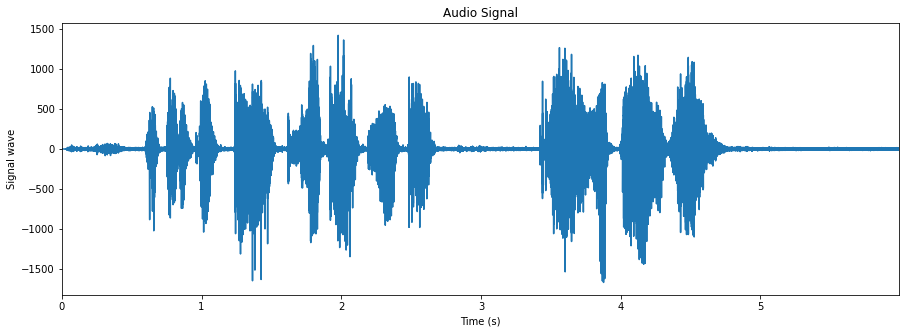

In [101]:
signal_array = np.frombuffer(frames, dtype=np.int16)
times = np.linspace(0, t_audio, num=w_obj.getnframes())
plt.figure(figsize=(15, 5))
plt.plot(times, signal_array)
plt.title("Audio Signal")
plt.ylabel("Signal wave")
plt.xlabel("Time (s)")
plt.xlim(0, t_audio)
plt.show()


**Visualise Speeach Audio**

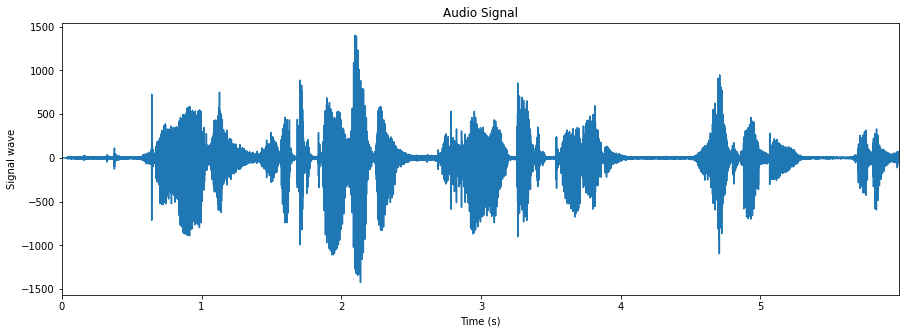

In [102]:
s_obj = wave.open("speech_output.wav")
s_frames = s_obj.readframes(-1)
signal_array = np.frombuffer(s_frames, dtype=np.int16)
times = np.linspace(0, t_audio, num=s_obj.getnframes())
plt.figure(figsize=(15, 5))
plt.plot(times, signal_array)
plt.title("Audio Signal")
plt.ylabel("Signal wave")
plt.xlabel("Time (s)")
plt.xlim(0, t_audio)
plt.show()


**Visualise Blank Audio**

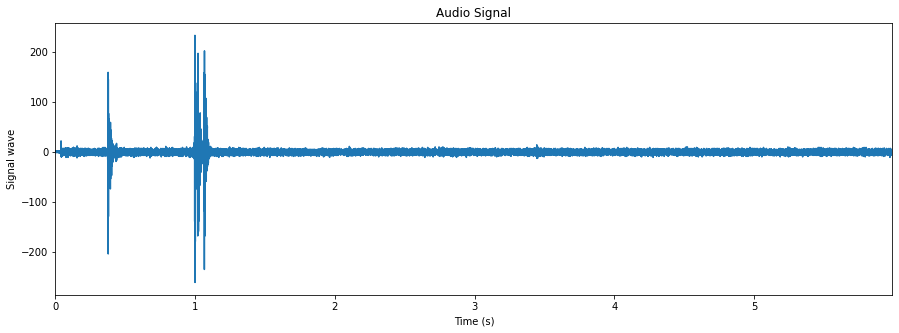

In [103]:
b_obj = wave.open("blank_output.wav")
b_frames = b_obj.readframes(-1)
signal_array = np.frombuffer(b_frames, dtype=np.int16)
times = np.linspace(0, t_audio, num=b_obj.getnframes())
plt.figure(figsize=(15, 5))
plt.plot(times, signal_array)
plt.title("Audio Signal")
plt.ylabel("Signal wave")
plt.xlabel("Time (s)")
plt.xlim(0, t_audio)
plt.show()


#### Data Preparation
* Open the output file
* Feed the output file to Speeach Recognisation API
* Analyse the Audio


**Opening the output file and using the Google API to get the text and analysing it**

In [104]:

# obtain path to "Daily_English_Conversation_02_Do_you_speak_English.wav" in the same folder as this script
AUDIO_FILE = path.join("output.wav")
sentence = []

# use the audio file as the audio source
r = sr.Recognizer()
with sr.AudioFile(AUDIO_FILE) as source:
    print("Say something!")
    audio = r.record(source)  # read the entire audio file
try:
    # for testing purposes, we're just using the default API key
    # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
    # instead of `r.recognize_google(audio)`
    print("Decoded Audio:\n"+ r.recognize_google(audio))
    sentence.append(r.recognize_google(audio))
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))

Say something!
Decoded Audio:
it's a good day for start working happy hours


**Generating** a **wordcloud** to see what words are contained in our sentence

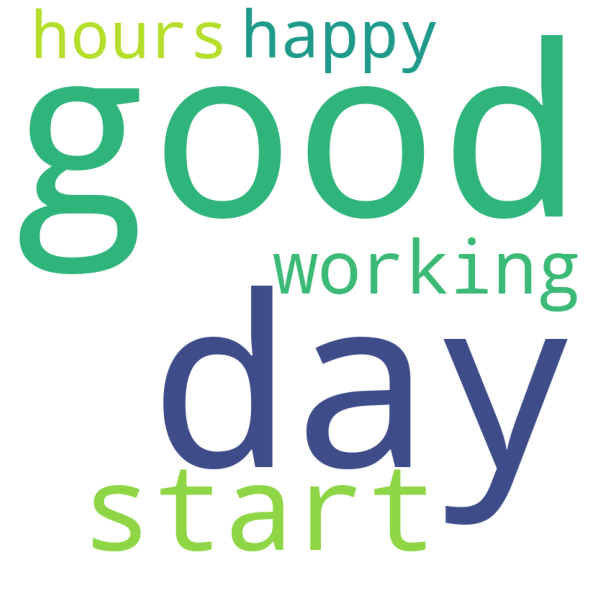

In [105]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(sentence[0])
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

##### Vectorisation of the data and importing datasets for analysis

In [106]:


filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
try :
    vectorizer.fit(sentence)
    vectorizer.vocabulary_
    predictor=vectorizer.transform(sentence)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
except :
    print("Improper Audio Input, please check if the audio is recorded and has speeach in it")

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


#### Modeling
Using the prepared data to run through a model prepared to train the model to determine the desirable outcome, in this case **Happy** or **Sad**

In [107]:

try :
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)

    print("Accuracy:", score)
except :
    print("No Input Provided")

Accuracy: 0.524


#### Evaluation
Checking the accuracy against the refernce data set , that is yelp, amazon, imdb data.

In [108]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    predictor = vectorizer.transform(sentence)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [109]:
try :
    modsent = str(sentence).replace('[','').replace(']','')

    if model.predict(predictor) == 1:
        print(modsent+" -> This Statment says you are Happy")
    else: print(modsent+" -> This Statment says you are Sad")
except :
    print("The Output is not available as there is no input")

"it's a good day for start working happy hours" -> This Statment says you are Sad


#### Deployment of the model

In [110]:
pickle.dump(model, open('model.pkl', 'wb'))


### Using the Pickled Model
Deployment has many options as per availabe resources , we have loaded and run the model as our option 1 states.
1. We can use the pickled model as shown below
2. we can use it as a static file in a flask or any web python framework
3. We can use it as a simple python file in a local application

In [111]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(X_test)


try :
    modsent = str(sentence).replace('[','').replace(']','')

    if pickled_model.predict(predictor) == 1:
        print(modsent+" -> This Statment says you are Happy")
    else: print(modsent+" -> This Statment says you are Sad")
except :
    print("The Output is not available as there is no input")

"it's a good day for start working happy hours" -> This Statment says you are Sad


In [112]:
ifile = wave.open("output.wav")
samples = ifile.getnframes()
audio = ifile.readframes(samples)

# Convert buffer to float32 using NumPy                                                                                 
audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

In [113]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model_wv = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:754: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
input_values = tokenizer(audio_as_np_float32, return_tensors="pt").input_values


In [115]:
logits = model_wv(input_values).logits


In [116]:
prediction = torch.argmax(logits, dim=-1)


In [117]:
transcription = tokenizer.batch_decode(prediction)[0]


In [118]:
print(transcription)


MASH I AH WISH YO ANT  O
